In [205]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError


In [206]:
quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

In [207]:
df=pd.read_csv('wine.csv', delimiter=';')
num_inputs = list(df.columns)
num=int(len(num_inputs))
num

12

<AxesSubplot:>

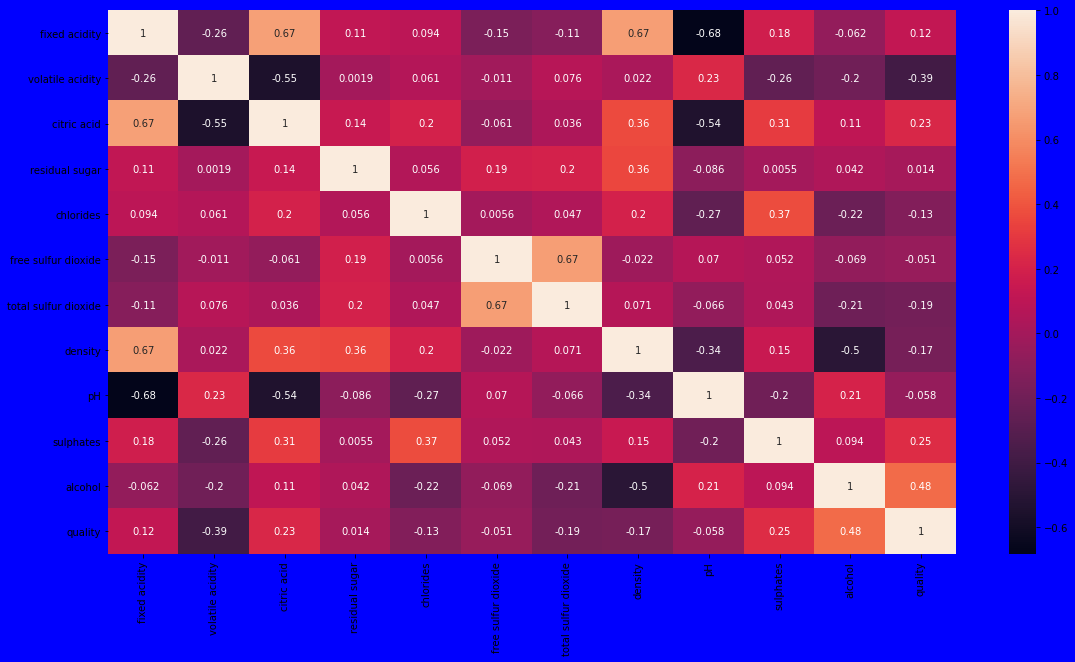

In [208]:
plt.figure(figsize=[19,10],facecolor='blue')
sb.heatmap(df.corr(),annot=True)

In [209]:
for a in range(len(df.corr().columns)):
    for b in range(a):
        if abs(df.corr().iloc[a,b]) >0.7:
            name = df.corr().columns[a]
            print(name)

In [210]:
new_df=df.drop('total sulfur dioxide',axis=1)

In [212]:
num_inputs = list(new_df.columns)
num=int(len(num_inputs))
num

11

In [213]:
num_rows = list(df.iloc)
num_r=int(len(num_rows))
num_r

1599

In [214]:
train_size = 1119
sample_train = num_rows[:train_size]

In [215]:
test_size = 1120
sample_test = num_rows[test_size:]

In [216]:
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

In [217]:
print(new_df)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

In [219]:
print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fixed acidity        1599 non-null   float64
 1   volatile acidity     1599 non-null   float64
 2   citric acid          1599 non-null   float64
 3   residual sugar       1599 non-null   float64
 4   chlorides            1599 non-null   float64
 5   free sulfur dioxide  1599 non-null   float64
 6   density              1599 non-null   float64
 7   pH                   1599 non-null   float64
 8   sulphates            1599 non-null   float64
 9   alcohol              1599 non-null   float64
 10  quality              1599 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 137.5 KB
None


In [218]:
print(new_df.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide      density           pH  \
count  1599.000000          1599.000000  1599.000000  1599.000000   
mean      0.087467            15.874922     0.996747     3.311113   
std       0.047065            10.460157     0.001887     0.154386   
min       0.012000             1.000000     0.990070     2.740000   
25%       0.070

In [220]:
print(sample_train)
print(sample_test)

[[-0.71216807  0.99703955 -1.4893813  ... -0.59231494 -0.86987119
  -0.80307622]
 [-0.48928565  2.00329637 -1.4893813  ...  0.08120568 -0.49742586
  -0.80307622]
 [-0.48928565  1.33245849 -1.28809897 ... -0.08717447 -0.49742586
  -0.80307622]
 ...
 [-0.93505048  0.94113639 -1.13713722 ... -0.36780806  0.89924411
   0.43132253]
 [-0.93505048  0.94113639 -1.13713722 ... -0.36780806  0.89924411
   0.43132253]
 [-0.87932988 -0.73595832 -0.88553432 ... -0.76069509  2.76147075
   0.43132253]]
[[-0.43356505  0.10258904  0.22151849 ...  0.30571255  2.57524809
   2.90012003]
 [-1.15793289 -0.12102359 -1.4893813  ... -0.64844165  1.83035743
   0.43132253]
 [-1.3250947  -0.28873306 -1.4893813  ... -1.04132868  1.83035743
   0.43132253]
 ...
 [-1.3250947  -0.06512043 -0.83521373 ...  0.47409271  0.61991012
   0.43132253]
 [-1.54797711  0.68957218 -0.88553432 ...  0.24958583 -0.12498054
  -0.80307622]
 [-1.49225651 -1.18318357  0.87568605 ... -0.03104776  0.61991012
   0.43132253]]


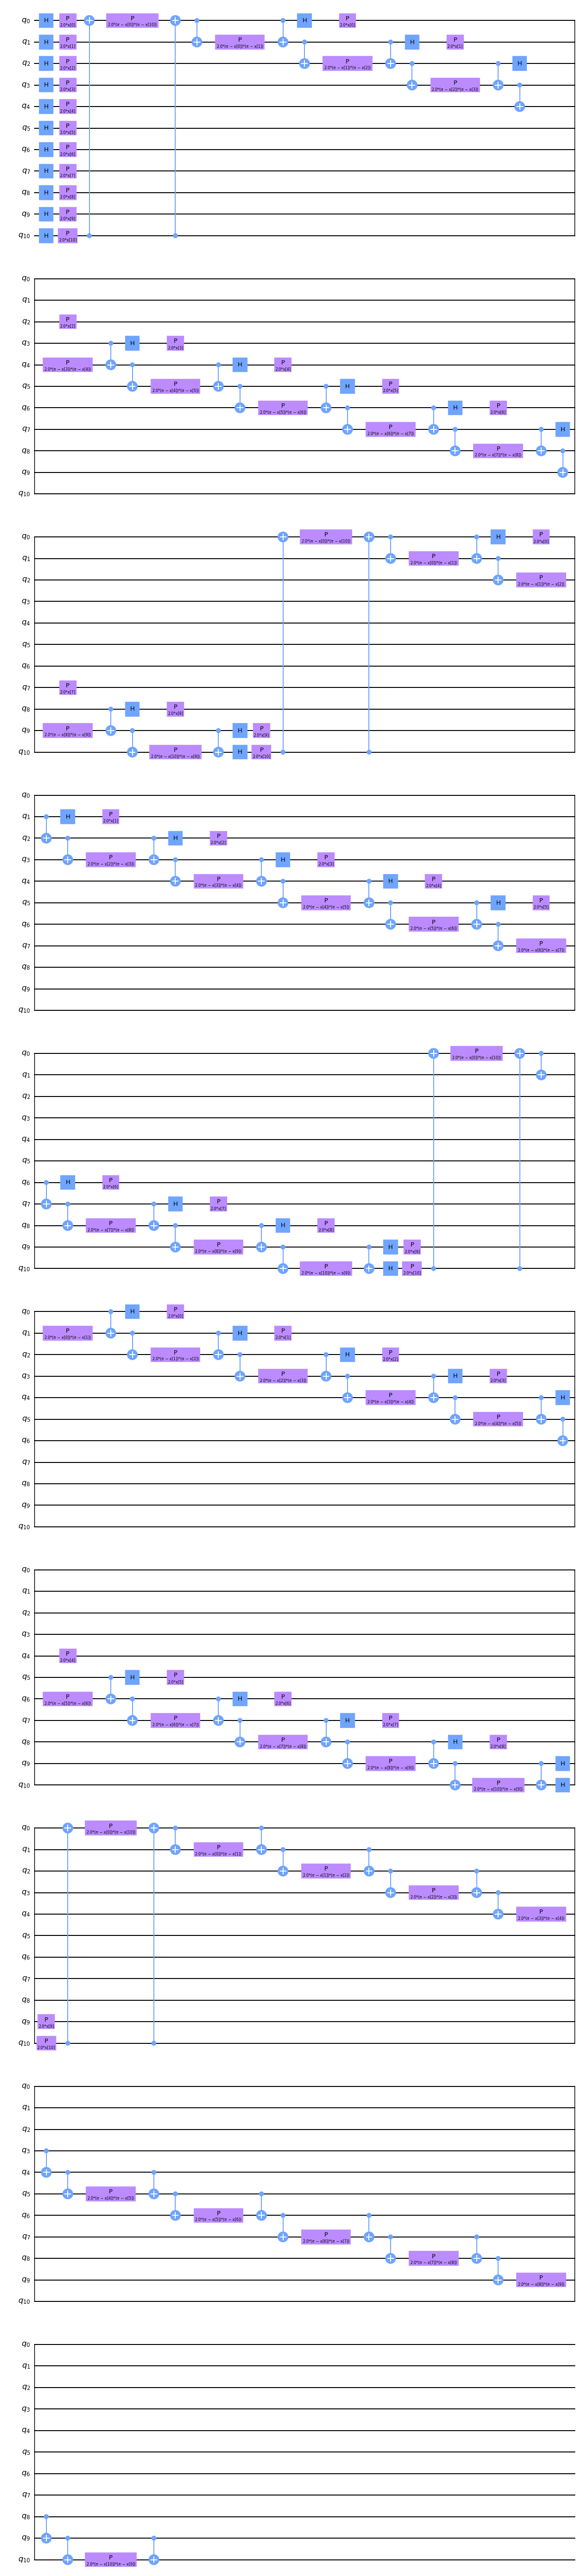

In [221]:
feature_map = ZZFeatureMap(num, reps=4, entanglement='circular')
ansatz = RealAmplitudes(num, reps=3)
feature_map.draw(output="mpl")

In [222]:
vqc = VQC(feature_map=feature_map, ansatz=ansatz, loss='cross_entropy', optimizer=COBYLA(), quantum_instance=quantum_instance)

In [226]:
y_one_hot = np.zeros((1159, 12))

In [227]:
y_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [230]:
# fit classifier to data
vqc.fit(new_df, y_one_hot)


QiskitMachineLearningError: 'Current settings only applicable to binary classification! Got labels: [[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n ...\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0.]]'